### Лабораторна робота #5, Людомирський Юрій, КА-96, v23
#### Загальна постановка задачі.
1. Взяти файл з даними у вiдповiдностi з варiантом.
---
2. Побудувати частi набори та асоцiативнi правила (АП), використовуючи алгоритм Apriori. Дослiдити множини АП залежно вiд параметрiв побудови АП:
- мiнiмальної пiдтримки;
- мiнiмальної достовiрностi;
- максимальної потужностi частих наборiв.
Пiдiбрати значення параметрiв алгоритму Apriori, якi призводять до значущих АП. АП R_k вважати значущим, якщо покращення (improvement або лiфт (lift)): Improv(R_k) > 1.
---
3. Побудувати частi набори та множину АП, використовуючи алгоритм FP-росту. Дослiдити множини АП залежно вiд параметрiв побудови АП, якi було наведено вище для Apriori. Пiдiбрати значення параметрiв алгоритму FP-росту, якi призводять до значущих АП.
---
4. Зробити висновки щодо впливу параметрiв алгоритмiв Apriori та FP-росту на знайденi множини АП.
---
5. Знайти значення прогнозу на основi побудованої множини правил.
---
6. Порiвняти результати, отриманi алгоритмами Apriori та FP-росту.
---

#### Початкові дані згідно варіанту.
1. Var_7_500_Transactions

### Imports

In [23]:
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
import mlxtend as ml

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Метод для модифікації таблиці для навчання

In [24]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

### Завантаження та аналіз датасету

In [25]:
df = pd.read_csv('dataset.csv')

In [26]:
df

,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035
...,...,...
4763,500,21903
4764,500,34969
4765,500,13517
4766,500,17795


Датасет складається з 2 колонок — order_id (номер транзакції) та product_id (продукти, що купляють). Загалом було зроблено 4768 транзакцій.

In [27]:
df.isnull().sum() 

order_id      0
product_id    0
dtype: int64

Нульових елементів не спостерігається.

In [28]:
df['order_id'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  35,  37,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 19

In [29]:
len(df['order_id'].unique())

472

In [30]:
df['product_id'].unique()

array([33120, 28985,  9327, ..., 19450, 46650, 13517])

In [31]:
len(df['product_id'].unique())

2714

Загалом маємо 472 унікальні транзакції та 2714 видів продуктів.

### Частота замовлень товарів

In [32]:
counts = df['product_id'].value_counts()
percent = df['product_id'].value_counts(normalize=True).mul(100).round(5).astype(str) + '%'

percentage = pd.DataFrame({'quantity': counts, '%': percent})
percentage

,quantity,%
24852,67,1.4052%
13176,54,1.13255%
21903,37,0.77601%
47209,30,0.62919%
16797,29,0.60822%
...,...,...
11256,1,0.02097%
27644,1,0.02097%
47337,1,0.02097%
39938,1,0.02097%


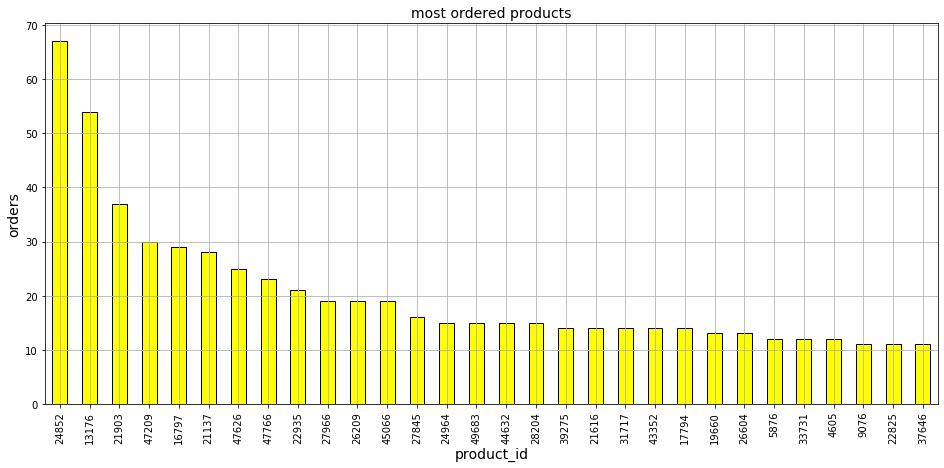

In [33]:
fig, ax = plt.subplots(figsize=(16,7))

df['product_id'].value_counts().sort_values(ascending=False).head(30).plot.bar(width=0.5,
                                                                               edgecolor = 'black',
                                                                               color = 'yellow',
                                                                               align = 'center',
                                                                               linewidth = 1)
plt.xlabel('product_id', fontsize=14)
plt.ylabel('orders', fontsize=14)

plt.title('most ordered products',fontsize=14)
plt.grid()

### Підготовка датасету для навчання

In [34]:
df_modif = df.groupby(["order_id", "product_id"]).size().reset_index(name="Count")

df_ml = (df_modif.groupby(['order_id', 'product_id'])['Count'].sum().unstack().reset_index().fillna(0).set_index('order_id'))
df_ml

product_id,28,34,45,54,86,148,162,169,196,204,...,49519,49520,49533,49588,49605,49610,49621,49628,49667,49683
order_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df_ml = df_ml.applymap(encode_units)
df_ml

product_id,28,34,45,54,86,148,162,169,196,204,...,49519,49520,49533,49588,49605,49610,49621,49628,49667,49683
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_ml.sum()

product_id
28        1
34        1
45        5
54        1
86        1
         ..
49610     1
49621     1
49628     1
49667     1
49683    15
Length: 2714, dtype: int64

Легко помітити, що все спрацювало правильно, таблиця не цілком порожня.

### Алгоритм Apriori

In [37]:
%%time

sets = apriori(df_ml, min_support = 0.02, use_colnames=True)
rules = association_rules(sets, metric='lift', min_threshold=0.5)
rules

CPU times: user 37.9 ms, sys: 168 µs, total: 38.1 ms
Wall time: 37.6 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(24852),(21903),0.141949,0.078390,0.029661,0.208955,2.665591,0.018534,1.165054
1,(21903),(24852),0.078390,0.141949,0.029661,0.378378,2.665591,0.018534,1.380343


Для мінімальної підтримки 0.02 маємо лише два правила, тож зменшимо до 0.01.

In [38]:
%%time

sets = apriori(df_ml, min_support = 0.01, use_colnames=True)
rules = association_rules(sets, metric='lift', min_threshold=0.5)
rules

CPU times: user 84.4 ms, sys: 76.6 ms, total: 161 ms
Wall time: 162 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1158),(21903),0.014831,0.078390,0.010593,0.714286,9.111969,0.009431,3.225636
1,(21903),(1158),0.078390,0.014831,0.010593,0.135135,9.111969,0.009431,1.139102
2,(9076),(24852),0.023305,0.141949,0.014831,0.636364,4.483039,0.011522,2.359640
3,(24852),(9076),0.141949,0.023305,0.014831,0.104478,4.483039,0.011522,1.090643
4,(12341),(16797),0.019068,0.061441,0.010593,0.555556,9.042146,0.009422,2.111758
5,(16797),(12341),0.061441,0.019068,0.010593,0.172414,9.042146,0.009422,1.185293
6,(13176),(21137),0.114407,0.059322,0.012712,0.111111,1.873016,0.005925,1.058263
7,(21137),(13176),0.059322,0.114407,0.012712,0.214286,1.873016,0.005925,1.127119
8,(13176),(22935),0.114407,0.044492,0.014831,0.129630,2.913580,0.009740,1.097818
9,(22935),(13176),0.044492,0.114407,0.014831,0.333333,2.913580,0.009740,1.328390


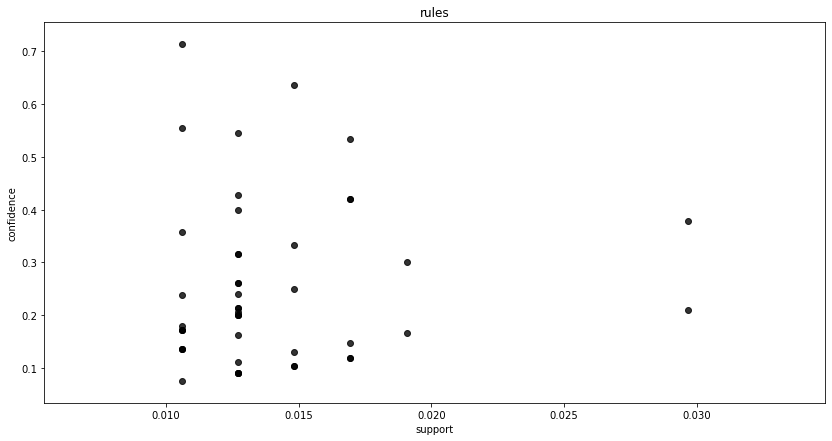

In [39]:
support = rules.support.to_numpy()
confidence = rules.confidence.to_numpy()

for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]

plt.figure(figsize=(14, 7))    
plt.title('rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns.regplot(x=support, y=confidence, fit_reg=False, color="black")
plt.show()

Правила з confidence більшою за 50%.

In [40]:
rules[(rules['lift'] >= 1) & (rules['confidence'] >= 0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1158),(21903),0.014831,0.078390,0.010593,0.714286,9.111969,0.009431,3.225636
2,(9076),(24852),0.023305,0.141949,0.014831,0.636364,4.483039,0.011522,2.359640
4,(12341),(16797),0.019068,0.061441,0.010593,0.555556,9.042146,0.009422,2.111758
35,(28204),(24852),0.031780,0.141949,0.016949,0.533333,3.757214,0.012438,1.838680
47,(37646),(47209),0.023305,0.063559,0.012712,0.545455,8.581818,0.011231,2.060169


### Алгоритм FP-росту

In [41]:
%%time

sets = fpgrowth(df_ml, min_support = 0.02, use_colnames=True)
rules = association_rules(sets, metric='lift', min_threshold=0.5)
rules

CPU times: user 48.8 ms, sys: 486 µs, total: 49.3 ms
Wall time: 49 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(24852),(21903),0.141949,0.078390,0.029661,0.208955,2.665591,0.018534,1.165054
1,(21903),(24852),0.078390,0.141949,0.029661,0.378378,2.665591,0.018534,1.380343


In [42]:
%%time

sets = fpgrowth(df_ml, min_support = 0.01, use_colnames=True)
rules = association_rules(sets, metric='lift', min_threshold=0.5)
rules

CPU times: user 57.3 ms, sys: 0 ns, total: 57.3 ms
Wall time: 56.9 ms


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(24852),(21903),0.141949,0.078390,0.029661,0.208955,2.665591,0.018534,1.165054
1,(21903),(24852),0.078390,0.141949,0.029661,0.378378,2.665591,0.018534,1.380343
2,(13176),(47209),0.114407,0.063559,0.019068,0.166667,2.622222,0.011796,1.123729
3,(47209),(13176),0.063559,0.114407,0.019068,0.300000,2.622222,0.011796,1.265133
4,(47209),(21903),0.063559,0.078390,0.012712,0.200000,2.551351,0.007729,1.152013
5,(21903),(47209),0.078390,0.063559,0.012712,0.162162,2.551351,0.007729,1.117687
6,(13176),(27966),0.114407,0.040254,0.016949,0.148148,3.680312,0.012344,1.126658
7,(27966),(13176),0.040254,0.114407,0.016949,0.421053,3.680312,0.012344,1.529661
8,(47209),(27966),0.063559,0.040254,0.012712,0.200000,4.968421,0.010153,1.199682
9,(27966),(47209),0.040254,0.063559,0.012712,0.315789,4.968421,0.010153,1.368644


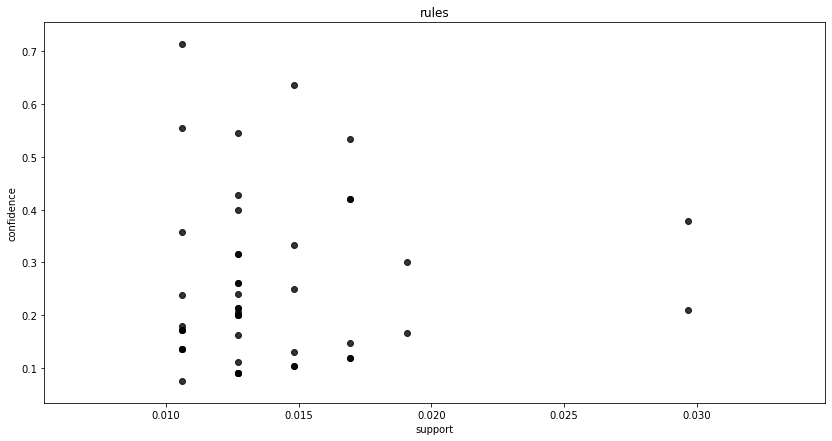

In [43]:
support = rules.support.to_numpy()
confidence = rules.confidence.to_numpy()

for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]

plt.figure(figsize=(14, 7))    
plt.title('rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns.regplot(x=support, y=confidence, fit_reg=False, color="black")
plt.show()

Правила з confidence більшою за 50%.

In [44]:
rules[(rules['lift'] >= 1) & (rules['confidence'] >= 0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
26,(1158),(21903),0.014831,0.078390,0.010593,0.714286,9.111969,0.009431,3.225636
35,(28204),(24852),0.031780,0.141949,0.016949,0.533333,3.757214,0.012438,1.838680
41,(37646),(47209),0.023305,0.063559,0.012712,0.545455,8.581818,0.011231,2.060169
42,(9076),(24852),0.023305,0.141949,0.014831,0.636364,4.483039,0.011522,2.359640
46,(12341),(16797),0.019068,0.061441,0.010593,0.555556,9.042146,0.009422,2.111758


### Висновки
Під час виконання роботи було вивчено та практично застосовано алгоритми Apriori та FP-росту. Отримані результати для confidence більшою за 50% виявились однаковими. У цьому конкретному випадку алгоритм FP-росту спрацював втричі швидше.